## First Task: Fruit segmentation and defect detection

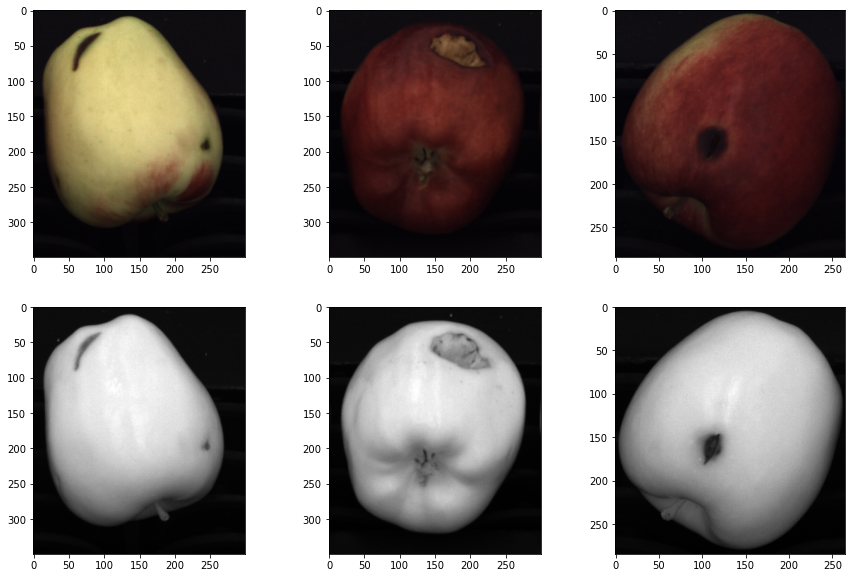

In [2]:
import cv2 as cv
import os
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import utils

# Directorio de las imágenes
img_directory = 'fruit-inspection-images/first task/'

# Obtener una lista de nombres de archivo en el directorio
file_names = [file for file in os.listdir(img_directory) if imghdr.what(os.path.join(img_directory, file))]

# Filtrar imágenes a color (C1) y blanco y negro (C0)
color_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_COLOR) for file in file_names if 'C1_' in file]
gray_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_GRAYSCALE) for file in file_names if 'C0_' in file]

# Verificar si las imágenes se cargaron correctamente
assert all(image is not None for image in color_images), "Error al leer las imágenes en color"
assert all(image is not None for image in gray_images), "Error al leer las imágenes en blanco y negro"

# Mostrar las imágenes utilizando matplotlib
utils.show_image(color_images, gray_images)

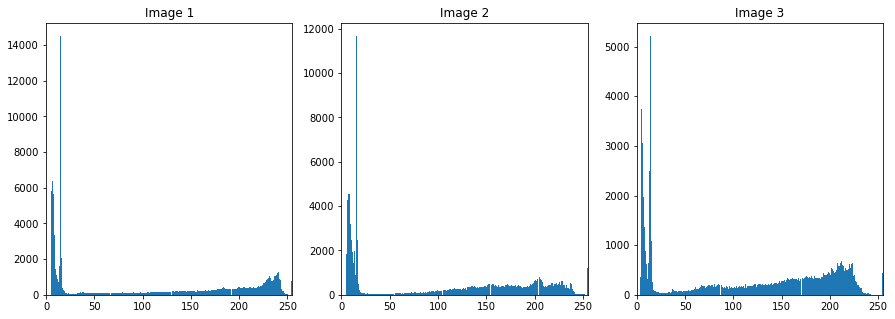

In [19]:
plt.figure(figsize=(15, 5))

for i, img in enumerate(gray_images):
    vals = img.flatten()
    plt.subplot(1,len(gray_images),i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

plt.show()

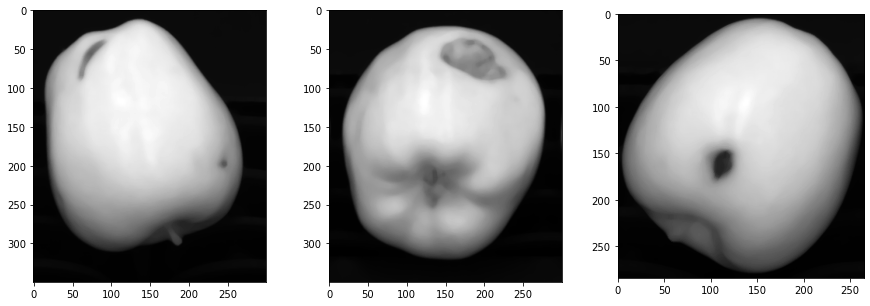

In [3]:
# Aplicar desenfoque para reducir el ruido
for i in range(len(gray_images)):
    gray_images[i] = cv.medianBlur(gray_images[i], 9)
utils.show_gray_image(gray_images)

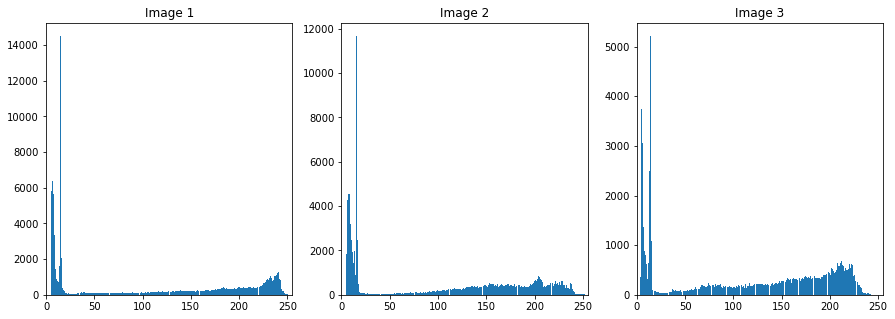

In [12]:
plt.figure(figsize=(15, 5))

for i, img in enumerate(gray_images):
    vals = img.flatten()
    plt.subplot(1,len(gray_images),i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

plt.show()

With this, we detected a threshold value for the three images around 50, since we tried to find the threshold automatically with the Otsu algorithm but obtained better results with the threshold of 50. It is then filled to have a perfect apple mask.


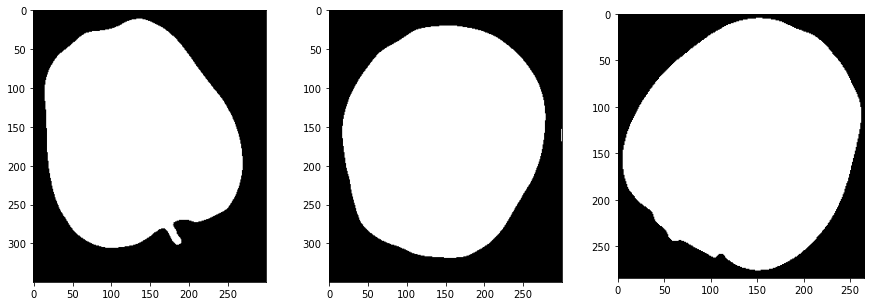

In [13]:
# Umbralizar la imagen
masks = []
i = 0;
for img in gray_images:
    ret, th1 = cv.threshold(img, 50, 255, cv.THRESH_BINARY)

    # Encontrar contornos en la imagen umbralizada
    contornos, _ = cv.findContours(th1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Crear una máscara inicial con el mismo tamaño que la imagen
    mask = np.zeros_like(img)

    # Dibujar los contornos en la máscara
    cv.drawContours(mask, contornos, -1, (255), thickness=cv.FILLED)
    
    # Encontrar un punto dentro de la fruta
    centroide = contornos[0].mean(axis=0)[0].astype(int)

    # Aplicar flood-fill para llenar los agujeros dentro del contorno
    cv.floodFill(mask, None, tuple(centroide), 255)
    masks.append(mask)
    i += 1

utils.show_gray_image(masks)

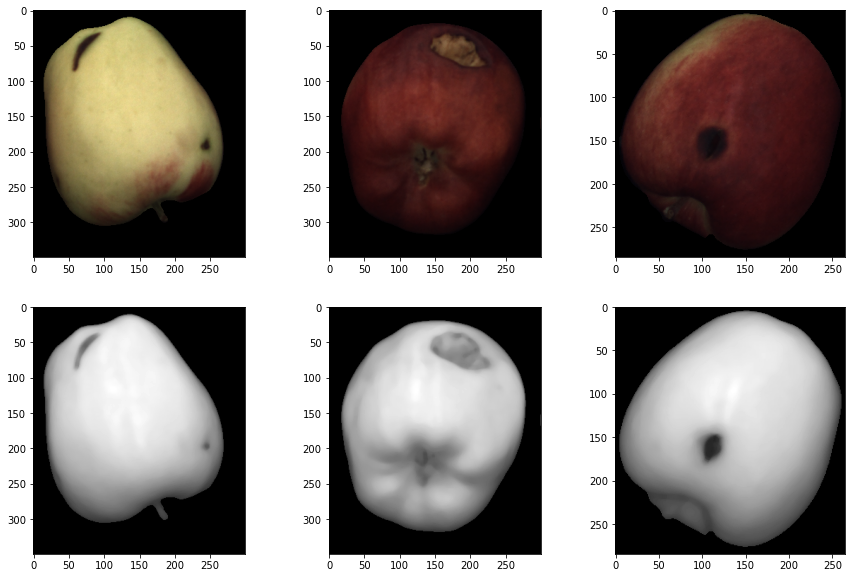

In [14]:
# Aplicar AND lógico entre la máscara y la imagen original
interes_bn = []
interes_c = []
for mask, img_color, img_gray in zip(masks, color_images, gray_images):
    interes_bn.append(cv.bitwise_and(img_gray, mask))
    interes_c.append(cv.bitwise_and(img_color, img_color, mask = mask))
    
utils.show_image(interes_c,interes_bn)

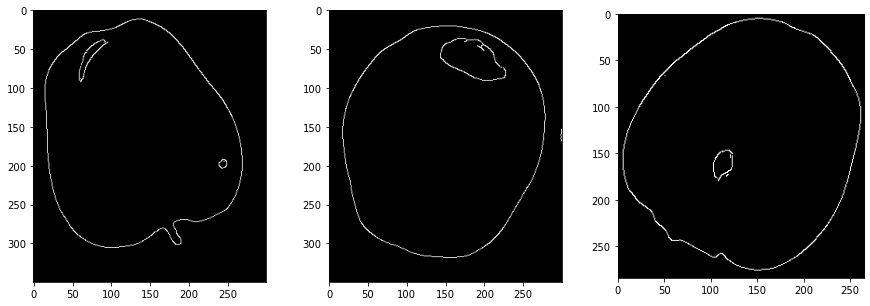

In [15]:
bordes_c = []
bordes_bn = []

for img_color, img_gray in zip(interes_c, interes_bn):
    bordes_c.append(cv.Canny(img_color, 50, 146))
    bordes_bn.append(cv.Canny(img_gray, 50, 146))
   
utils.show_gray_image(bordes_bn)

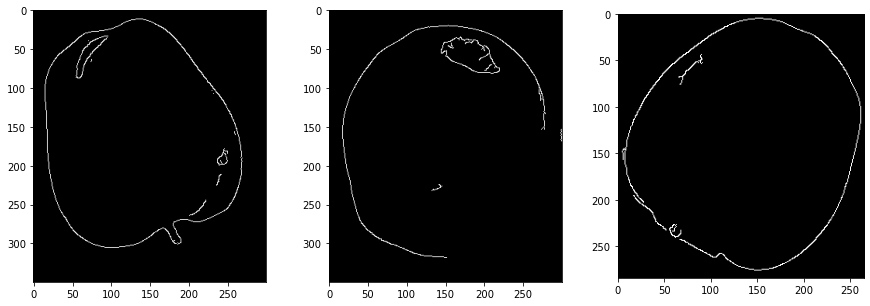

In [16]:
utils.show_gray_image(bordes_c)

We see in the bottom row that it does not work correctly to extract the edges directly from the color image so we have to do the preprocessing to transform it to grayscale.

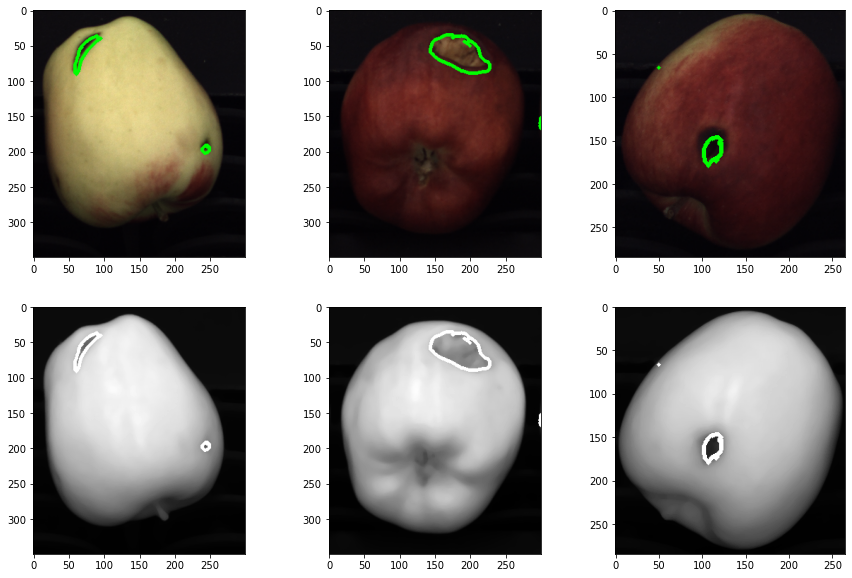

In [17]:
final_c = []
final_bn = []
i = 0
for bordes in bordes_bn:
    final_contornos,_= cv.findContours(bordes, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    final_c.append(cv.drawContours(color_images[i], final_contornos[:-2], -1, (0, 255, 0), 3))
    final_bn.append(cv.drawContours(gray_images[i], final_contornos[:-2], -1, 255, 3))
    i += 1
    

utils.show_image(final_c,final_bn)

Defects correctly found